In [1]:
import matplotlib.pyplot as plt
import vista
import os
import torch
from torch import nn
from memory import Memory
from tqdm import tqdm
import numpy as np
import argparse
from NeuralNetwork import Model
import torch
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim
import time
from IPython import display as ipythondisplay

2023-04-07 20:58:40,441::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


Using mps device


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
### Agent Memory ###

class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

In [4]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= torch.mean(x)
    x /= torch.std(x)
    return x

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = torch.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
      
    return normalize(discounted_rewards)

In [5]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, running_loss, custom_fwd_fn=None):
    # Forward propagate through the agent network
    if custom_fwd_fn is not None:
        prediction = custom_fwd_fn(observations)
    else: 
        prediction = model(observations)
    loss = loss_function(prediction, actions, discounted_rewards)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 2)
    optimizer.step()
    running_loss += loss.item()
    optimizer.zero_grad()
    return running_loss

2023-04-07 20:58:45,099::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-04-07 20:58:45,266::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-04-07 20:58:45,443::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-04-07 20:58:45,616::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-04-07 20:58:46,507::WARNING::[vista.entities.sensors.Camera.reset] No flow data


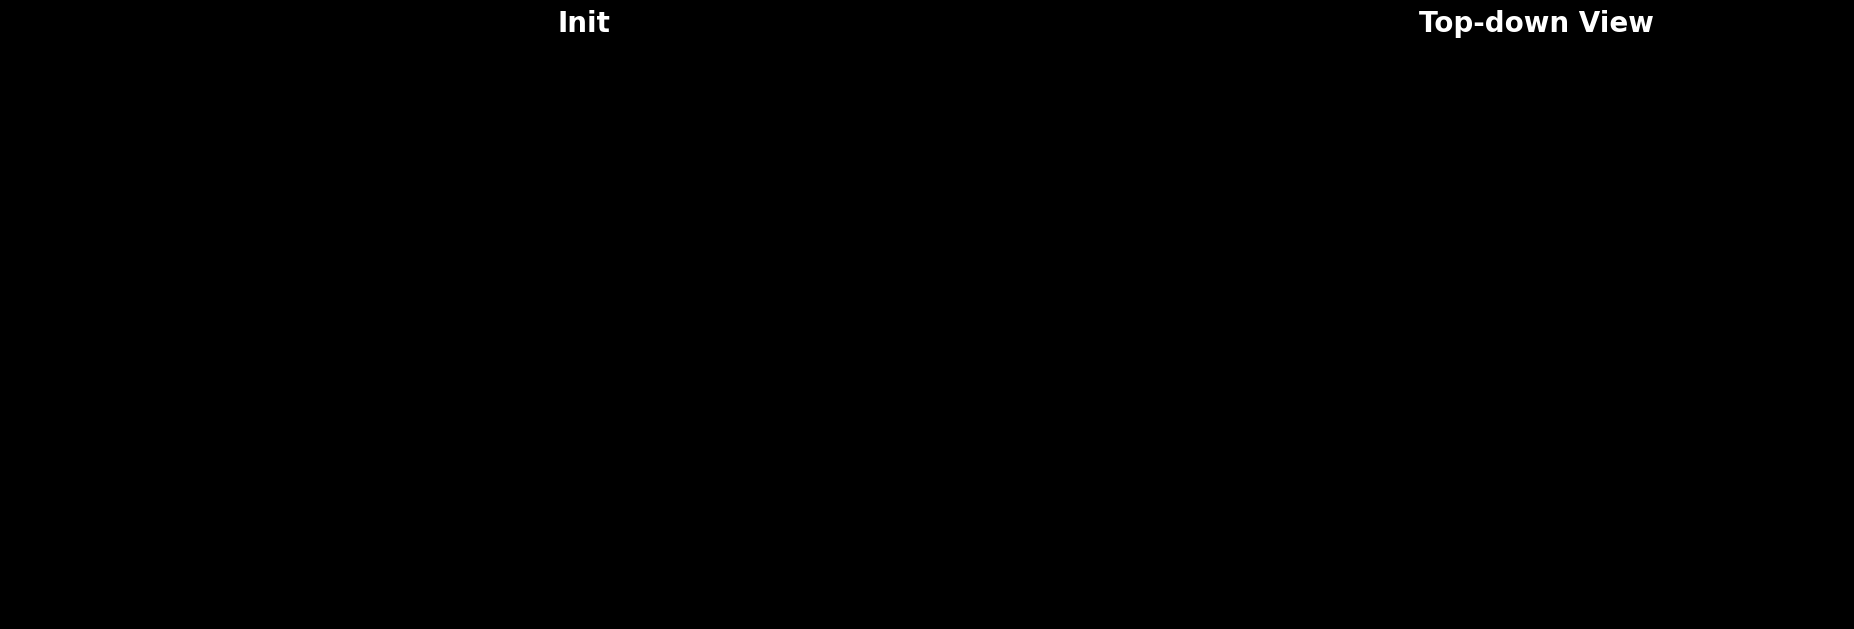

In [6]:
trace_root = "../trace"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]
world = vista.World(trace_path, trace_config={'road_width': 4})
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })
camera = car.spawn_camera(config={'size': (200, 320)})
display = vista.Display(world, display_config={"gui_scale": 2, "vis_full_frame": False})
def vista_reset():
    world.reset()
    display.reset()
vista_reset()

In [7]:
def vista_step(curvature=None, speed=None):
    # Arguments:
    #   curvature: curvature to step with
    #   speed: speed to step with
    if curvature is None: 
        curvature = car.trace.f_curvature(car.timestamp)
    if speed is None: 
        speed = car.trace.f_speed(car.timestamp)
    
    car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)
    car.step_sensors()

In [8]:
def check_out_of_lane(car):
    distance_from_center = np.abs(car.relative_state.x)
    road_width = car.trace.road_width 
    half_road_width = road_width / 2
    return distance_from_center > half_road_width

def check_exceed_max_rot(car):
    maximal_rotation = np.pi / 10.
    current_rotation = np.abs(car.relative_state.yaw)
    return current_rotation > maximal_rotation

def check_crash(car): 
    return check_out_of_lane(car) or check_exceed_max_rot(car) or car.done

In [9]:
## Data preprocessing functions ##

def preprocess(full_obs):
    # Extract ROI
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    
    # Rescale to [0, 1]
    obs = obs / 255.
    return obs

def grab_and_preprocess_obs(car):
    full_obs = car.observations[camera.name]
    obs = preprocess(full_obs)
    obs = torch.from_numpy(obs).to(torch.float32)
    return obs

In [135]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(48)

        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
        self.bn6 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(in_features=256 * 1 * 1, out_features=128)
        self.bn7 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.reshape(-1,256 * 1 * 1)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.fc2(x)

        return x

driving_model = Model()

In [157]:
import torchvision.models as models

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()

        # Load the pre-trained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=True)

        # Replace the last fully connected layer to output two numerical values
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        x = self.resnet50(x)
        return x
    
driving_model = ResNet50()

/Users/oliverchang/opt/anaconda3/envs/vista/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliverchang/opt/anaconda3/envs/vista/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [158]:
## The self-driving learning algorithm ##

# hyperparameters
max_curvature = 1/8. 
max_std = 0.1 

def run_driving_model(image):
    # Arguments:
    #   image: an input image
    # Returns:
    #   pred_dist: predicted distribution of control actions 
    single_image_input = len(image.shape) == 3  # missing 4th batch dimension
    if single_image_input:
        image = image.unsqueeze(0)

    image = image.permute(0,3,1,2)
    # print(f"input shape: {image.shape}")
    distribution = driving_model(image)

    mu, logsigma = torch.chunk(distribution, 2, dim=1)
    mu = max_curvature * torch.tanh(mu) # conversion
    sigma = max_std * torch.sigmoid(logsigma) + 0.005 # conversion

    pred_dist = dist.Normal(mu, sigma)
    return pred_dist


def compute_driving_loss(dist, actions, rewards):
    # Arguments:
    #   logits: network's predictions for actions to take
    #   actions: the actions the agent took in an episode
    #   rewards: the rewards the agent received in an episode
    # Returns:
    #   loss
    neg_logprob = -1 * dist.log_prob(actions)
    loss = torch.mean(neg_logprob * rewards) 
    print(f"loss: {loss}")
    return loss

In [159]:
class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [160]:
## Training parameters and initialization ##
## Re-run this cell to restart training from scratch ##

# instantiate driving agent
vista_reset()
driving_model = ResNet50()

learning_rate = 0.001 # 5e-4
optimizer = optim.SGD(driving_model.parameters(), lr=learning_rate)

# to track our progress
smoothed_reward = LossHistory(smoothing_factor=0.9)
smoothed_loss = LossHistory(smoothing_factor=0.9)
plotter_reward = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')
plotter_loss = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Episodic Loss')

# instantiate Memory buffer
memory = Memory()


2023-04-07 22:39:13,454::WARNING::[vista.entities.sensors.Camera.reset] No flow data
/Users/oliverchang/opt/anaconda3/envs/vista/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliverchang/opt/anaconda3/envs/vista/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


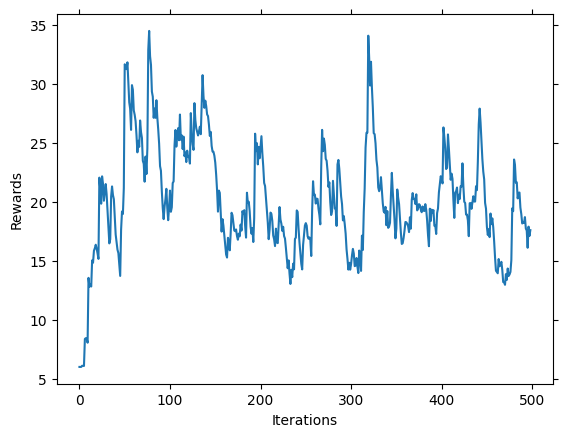

2023-04-08 09:26:37,602::WARNING::[vista.entities.sensors.Camera.reset] No flow data


Episode: 499
steps: 13
total reward: 12.0

loss: 0.31974485516548157


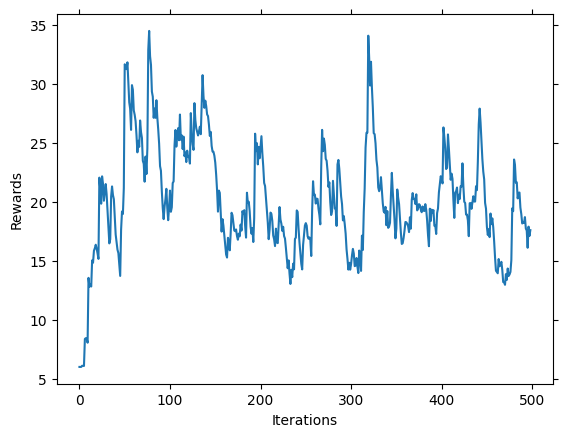

In [161]:
## Driving training! Main training block. ##
## Note: stopping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as
#        well (to re-initialize the model and optimizer)

max_batch_size = 300
max_reward = float("-inf")  # keep track of the maximum reward acheived during training
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists
for i_episode in range(500):
    driving_model.eval()
    plotter_reward.plot(smoothed_reward.get())
    # plotter_loss.plot(smoothed_loss.get())
    running_loss = 0
    # Restart the environment
    vista_reset()
    memory.clear()
    observation = grab_and_preprocess_obs(car)
    # plt.imshow(observation)
    # plt.pause(.5)
    steps = 0
    print(f"Episode: {i_episode}")

    while True:
        curvature_dist = run_driving_model(observation)
        curvature_action = curvature_dist.sample()[0, 0]

        # Step the simulated car with the same action
        vista_step(curvature_action)
        observation = grab_and_preprocess_obs(car)

        reward = 1.0 if not check_crash(car) else 0.0

        # add to memory
        memory.add_to_memory(observation, curvature_action, reward)
        steps += 1

        # is the episode over? did you crash or do so well that you're done?
        if reward == 0.0:
            driving_model.train()
            print(f"steps: {steps}")
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            print(f"total reward: {total_reward}\n")

            # execute training step - remember we don't know anything about how the
            #   agent is doing until it has crashed! if the training step is too large
            #   we need to sample a mini-batch for this step.
            batch_size = min(len(memory), max_batch_size)
            # print(f"batch size: {batch_size}")
            i = torch.randint(len(memory), (batch_size,), dtype=torch.long)
            # print(f"index: {i}")

            batch_observations = torch.stack(memory.observations, dim=0)
            batch_observations = torch.index_select(batch_observations, dim=0, index=i)

            # print(f"batch obs shape: {batch_observations.shape}")

            batch_actions = torch.stack(memory.actions)
            batch_actions = torch.index_select(
                batch_actions, dim=0, index=i
            )  # batch_action[i]

            # print(f"batch action shape: {batch_actions.shape}\n")

            batch_rewards = torch.tensor(memory.rewards)
            batch_rewards = discount_rewards(batch_rewards)[i]

            running_loss = train_step(
                driving_model,
                compute_driving_loss,
                optimizer,
                observations=batch_observations,
                actions=batch_actions,
                discounted_rewards=batch_rewards,
                running_loss=running_loss,
                custom_fwd_fn=run_driving_model,
            )
            # reset the memory
            episode_loss = running_loss / batch_size
            # print(f"episode loss: {episode_loss}")
            smoothed_loss.append(episode_loss)
            memory.clear()
            break
